# ROB 498: Robot Learning for Planning and Control
# Final Project: GPs for Bayesian Optimization

## Colab Setup

### Setup Code 

In [1]:
%load_ext autoreload
%autoreload 2

## If running in Colab:


In [2]:
from google.colab import drive
import os 
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/ROB498/gps-for-bayesian-optimization'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
files = os.listdir(GOOGLE_DRIVE_PATH)
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
# Install GPyTorch
!pip install GPyTorch

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import os
import sys

files = os.listdir()
#files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = ['learning_state_dynamics.py', 'panda_pushing_env.py', 'visualizers.py',  'mppi.py']

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

#sys.path.append(GOOGLE_DRIVE_PATH)

import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm
from learning_state_dynamics import collect_data_random
from learning_state_dynamics import process_data_single_step, SingleStepDynamicsDataset
OBS_INIT = 1


All required files are found :)


pybullet build time: May 20 2022 19:44:17


## Simulation Environment Introduction

For our planar pushing setup, we will use PyBullet to simulate a panda robot that pushes a block on top of a table.
The pushing block is visualized in white. In green, we visualize the goal pose of the block.



In [4]:
from panda_pushing_env import PandaPushingEnv
from visualizers import *

Run the following code block to visualize the robot pushing the block.

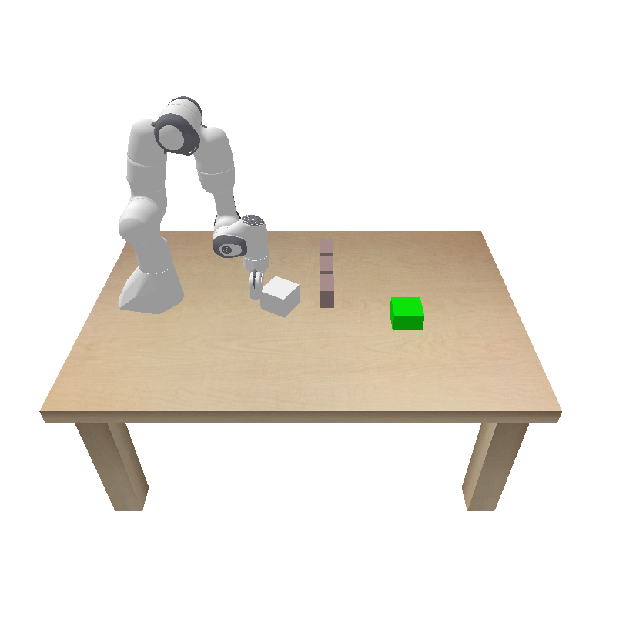

argv[0]=--opengl2


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
%matplotlib inline

OBS_INIT = 4
# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
# visualizer = NotebookAndGIFVisualizer(fig=fig, hfig=hfig, filename = "pushing_visualization_4.gif")
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  include_obstacle=True,
                    camera_heigh=800, camera_width=800, render_every_n_steps=5, obsInit = OBS_INIT)

env.reset()

# Perform a sequence of 3 random actions:
for i in tqdm(range(1)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break
# Image(filename=visualizer.get_gif())

plt.close(fig)

### State Space and Action Space

For the planar pushing task, we have the following action and state spaces:

The image below illustrates the state space, which is the block planar location on top of the table. 
$$
\mathbf x = \begin{bmatrix} x & y & \theta\end{bmatrix}^\top\in \text{SE}(2)
$$
Note that the state contains only position elements, and not velocity terms. This is because we assume that the pushing task is *quasi-static*. This means that the pushing actions are slow enough that the velocity and inertia of the block are negligible. In other words, if the robot stops pushing, the block also stops.


![State Space](https://drive.google.com/uc?export=view&id=1iuHwUC_IVsrBbgbyiR8qXDV4OBmgKObU)

Note that the robot is centered at the origin. 


The following image show the robot action space. 

![Action Space](https://drive.google.com/uc?export=view&id=1sFyNOAj-RmNbwk_Ww8VxmmkCaW4LpVZj)

Each action $\mathbf u = \begin{bmatrix} p & \phi & \ell\end{bmatrix}^\top\in \mathbb R^3$ is composed by:
* $p \in [-1,1]$: pushing location along the lower block edge.
* $\phi \in [-\frac{\pi}{2},\frac{\pi}{2}]$ pushing angle.
* $\ell\in [0,1]$ pushing length as a fraction of the maximum pushing length. The maximum pushing length is is 0.1 m



### Gym Environments

Our planar pushing task has been wrapped into a `gym` environment. You can find more information about the gym environments [here](https://gymnasium.farama.org/api/env/).

As a gym enviroment, our pushing enviroment has the following useful methods:

* `step`: Given an action vector, it performs the action in the simulator and returns 
    1. `state`: The resulting state, i.e. $s_{t+1}$
    2. `reward`: Not used here (useful for Reinforcement Learning tasks).
    3. `done`: Boolean. In our case the simulation is done (`done=True`) if the robot has reached the goal location or if the block has left the bounds of the workspace.
    4. `info`: Dictionary containing additional data. Not used here.
Example:
```python
state, reward, done, info = env.step(action_i)
```
* `reset`: Resets the simulation to the initial state. It returns the inital state after reset.
Example:
```python
    state = env.reset()
```

Moreover, our pushing environment has the following attributes:
* `env.action_space`: Represents the action space, following the described parametrization above.
* `env.observation_space`: Represents the state space (block pose in $SE(2)$)
These are `gym.spaces` and therefore you can sample them using `.sample()`.
Example:
```python
action_i = env.action_space.sample()
```
This produces actions uniformly sampled from the action space.

You can find more info about gym spaces [here](https://gymnasium.farama.org/api/spaces/).



## TODO: Implement TS-GP stuff, CMA-ES, modify cost functions to account for more obstacles

Add imports as necessary, will use multistep residual dynamics model, retrain on HW3 if necessary

In [13]:
from learning_state_dynamics import *
from panda_pushing_env import *

pushing_residual_dynamics_model = ResidualDynamicsModel(3,3)
model_path = os.path.join('pushing_multi_step_residual_dynamics_model.pt')
pushing_residual_dynamics_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

### Obstacle-Free Pushing 

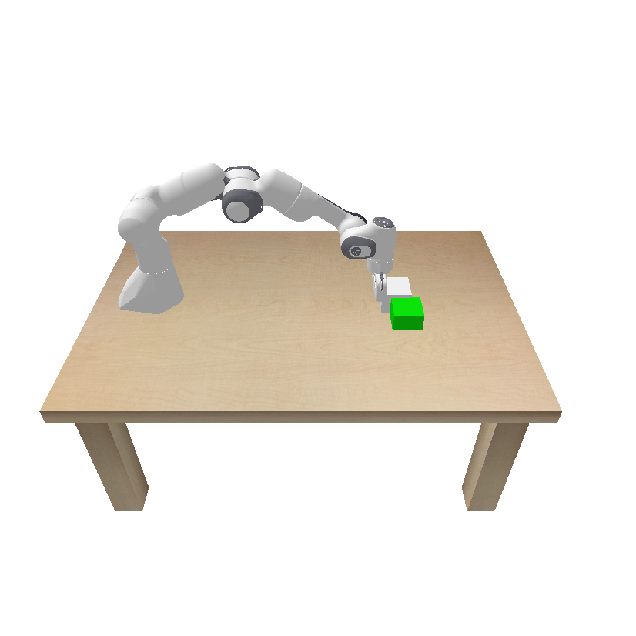

argv[0]=--opengl2


 50%|█████     | 10/20 [00:13<00:13,  1.31s/it]

GOAL REACHED: False


In [25]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, pushing_residual_dynamics_model, free_pushing_cost_function, num_samples=100, horizon=10)
env.reset()

state_0 = env.reset()
state = state_0

# num_steps_max = 100
num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_FREE
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')
        
plt.close(fig)

### Pushing with Obstacles

The obstacle we are considering is a rectangle. At a given SE2 pose $[x, y, \theta]$ we can check collision by checking whether or not these two rectangles intersect. 

![Action Space](https://drive.google.com/uc?export=view&id=1yC2SxtbtmhInkYk-rzR2TAAYuD4JM-I0)

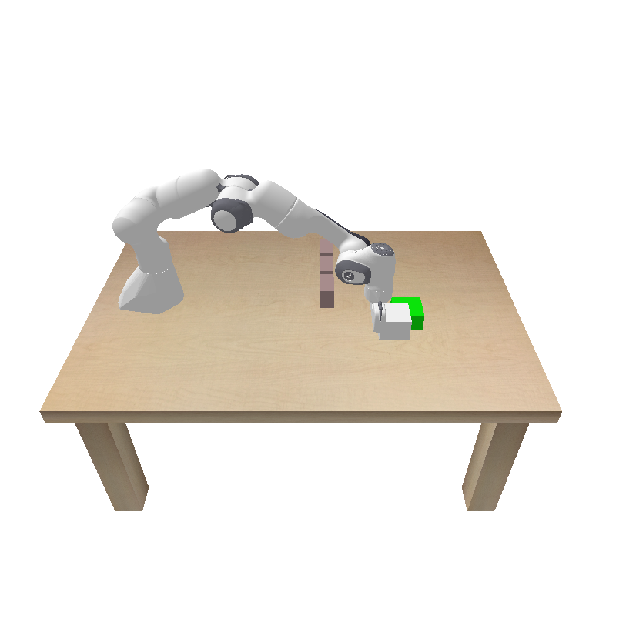

argv[0]=--opengl2


 35%|███▌      | 7/20 [00:14<00:26,  2.07s/it]


0.06972580901034874
GOAL REACHED: True
Creating animated gif, please wait about 10 seconds


In [15]:
from learning_state_dynamics import *
from panda_pushing_env import *

# Control on an obstacle free environment
%matplotlib inline
pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3,3)
model_path = os.path.join('pushing_multi_step_residual_dynamics_model.pt')
pushing_multistep_residual_dynamics_model.load_state_dict(torch.load(model_path))


fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookAndGIFVisualizer(fig=fig, hfig=hfig)
# set up controller and environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  include_obstacle=True, camera_heigh=800, 
                      camera_width=800, render_every_n_steps=5, obsInit=OBS_INIT)
state_0 = env.reset()
state = state_0

controller = PushingController(env, pushing_multistep_residual_dynamics_model,
                               obstacle_avoidance_pushing_cost_function, num_samples=1000, horizon=20)


num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_OBSTACLES
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE
print(goal_distance)
print(f'GOAL REACHED: {goal_reached}')


Image(filename=visualizer.get_gif())

        
# Evaluate state
plt.close(fig)

## Data Collection

In [16]:
from OptimizeHP import collect_data_GP
from learning_state_dynamics import ResidualDynamicsModel, PushingController, obstacle_avoidance_pushing_cost_function

pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3,3)
pushing_multistep_residual_dynamics_model.eval()
model_path = os.path.join('pushing_multi_step_residual_dynamics_model.pt')
pushing_multistep_residual_dynamics_model.load_state_dict(torch.load(model_path))

#optional visualizer for ensuring the correct environment is chosen
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

data_types = ['collected_data_OBS_1.npy',
              'collected_data_OBS_2.npy',
              'collected_data_OBS_3.npy']
for i in range(3):
    env = PandaPushingEnv(visualizer=None, render_non_push_motions=False,  include_obstacle=True, camera_heigh=800,
                        camera_width=800, render_every_n_steps=5, obsInit = i+1)
    env.reset()
    controller = PushingController(env, pushing_multistep_residual_dynamics_model,
                            obstacle_avoidance_pushing_cost_function, num_samples=1000, horizon=30)
    collected_data = collect_data_GP(env, controller)
    np.save(os.path.join(data_types[i]), collected_data)

<Figure size 800x800 with 0 Axes>

/home/rob530/.local/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


argv[0]=--opengl2


Iteration: 1:   0%|          | 1/500 [00:28<3:57:33, 28.56s/it]


KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

## Combine Collected Data

In [5]:
collected_data = []
data = ['collected_data.npy']
for d in data:
    collected_data.append(np.load(os.path.join(d), allow_pickle=True))
np.save(os.path.join('collected_data_cat.npy'), collected_data)

## Load Collected Data

In [21]:
data_types = ['collected_data_OBS_1.npy',
              'collected_data_OBS_2.npy',
              'collected_data_OBS_3.npy']

data = np.load(os.path.join(data_types[OBS_INIT-1]), allow_pickle=True)
data = data.reshape(-1)
collected_data = {}

collected_data['hyperparameters'] = torch.from_numpy(np.stack([d['hyperparameters'] for d in data], axis=0)).type(torch.float64)
collected_data['cost'] = torch.from_numpy(np.stack([d['cost'] for d in data], axis=0)).type(torch.float64)

## Train GP Hyperparameters

In [24]:
import gpytorch
from OptimizeHP import RBF_GP, train_gp_hyperparams
likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_x = collected_data['hyperparameters'] 
train_y = collected_data['cost']

model = RBF_GP(train_x, train_y, likelihood)
model.eval()
likelihood.eval()

train_gp_hyperparams(model, likelihood, collected_data['hyperparameters'], collected_data['cost'], mute = True)

save_path = os.path.join('RBF_GP_model.pth')
torch.save(model.state_dict(), save_path)

Iter 1/2000 - Loss: 559.040
Iter 2/2000 - Loss: 466.939
Iter 3/2000 - Loss: 390.044
Iter 4/2000 - Loss: 327.050
Iter 5/2000 - Loss: 276.196
Iter 6/2000 - Loss: 235.539
Iter 7/2000 - Loss: 203.182
Iter 8/2000 - Loss: 177.427
Iter 9/2000 - Loss: 156.843
Iter 10/2000 - Loss: 140.277
Iter 11/2000 - Loss: 126.827
Iter 12/2000 - Loss: 115.796
Iter 13/2000 - Loss: 106.656
Iter 14/2000 - Loss: 99.003
Iter 15/2000 - Loss: 92.529
Iter 16/2000 - Loss: 86.999
Iter 17/2000 - Loss: 82.233
Iter 18/2000 - Loss: 78.091
Iter 19/2000 - Loss: 74.462
Iter 20/2000 - Loss: 71.260
Iter 21/2000 - Loss: 68.417
Iter 22/2000 - Loss: 65.876
Iter 23/2000 - Loss: 63.594
Iter 24/2000 - Loss: 61.533
Iter 25/2000 - Loss: 59.663
Iter 26/2000 - Loss: 57.959
Iter 27/2000 - Loss: 56.401
Iter 28/2000 - Loss: 54.971
Iter 29/2000 - Loss: 53.654
Iter 30/2000 - Loss: 52.436
Iter 31/2000 - Loss: 51.307
Iter 32/2000 - Loss: 50.258
Iter 33/2000 - Loss: 49.280
Iter 34/2000 - Loss: 48.366
Iter 35/2000 - Loss: 47.510
Iter 36/2000 - L

KeyboardInterrupt: 

## Load GP Hyperparameters and run Thompson Sampling

In [25]:
from OptimizeHP import ThompsonSamplingGP, RBF_GP, execution_cost
from learning_state_dynamics import ResidualDynamicsModel, PushingController, obstacle_avoidance_pushing_cost_function

GP_state_dict = torch.load('RBF_GP_model.pth')
likelihood = gpytorch.likelihoods.GaussianLikelihood()

pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3,3)
pushing_multistep_residual_dynamics_model.eval()
model_path = os.path.join('pushing_multi_step_residual_dynamics_model.pt')
pushing_multistep_residual_dynamics_model.load_state_dict(torch.load(model_path))

HP = torch.load(os.path.join('HP.pt'))
cost = torch.load(os.path.join('cost.pt'))

# prior = [HP, cost]

In [26]:
constraints = torch.tensor([[0, 10],
                            [0, 0.015],
                            [0, 5],
                            [0, 5],
                            [0, 5]])

TS = ThompsonSamplingGP(GP_state_dict, likelihood, constraints, pushing_multistep_residual_dynamics_model, 
                        train_x, train_y, prior = None, obsInit = OBS_INIT)
optimum_hp, optimum_cost = TS.getOptimalParameters()

TS_HP = TS.X
TS_cost = TS.y

# TS_HP = torch.vstack((HP, TS.X))
# TS_cost = torch.vstack((cost,TS.y))

torch.save(TS_HP, os.path.join('HP.pt'))
torch.save(TS_cost, os.path.join('cost.pt'))
print(optimum_hp)
print(optimum_cost)

/home/rob530/.local/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


argv[0]=--opengl2


100%|██████████| 500/500 [2:33:47<00:00, 18.45s/it]  

tensor([4.6947, 0.0070, 2.3473, 2.3473, 2.3473], dtype=torch.float64)
tensor([12.4379], dtype=torch.float64)


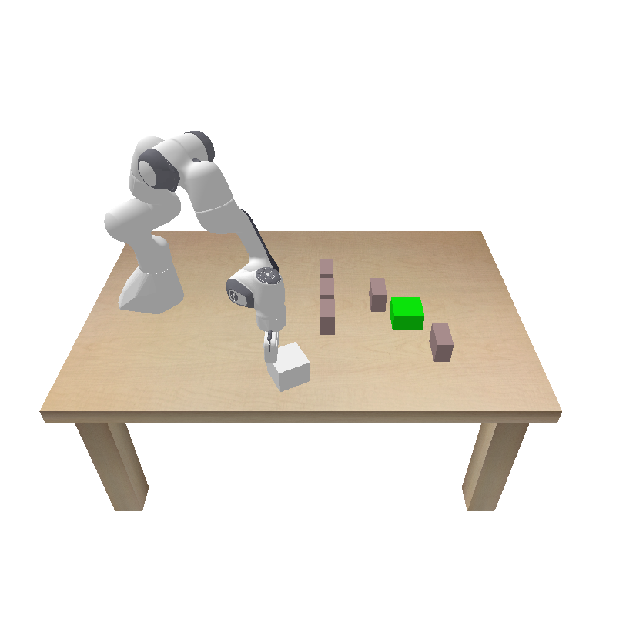

argv[0]=--opengl2


  0%|          | 0/20 [00:00<?, ?it/s]

0.4696512336084449
GOAL REACHED: False
Creating animated gif, please wait about 10 seconds


In [10]:
from panda_pushing_env import BOX_SIZE, TARGET_POSE_OBSTACLES

HP = torch.load(os.path.join('HP.pt'))
cost = torch.load(os.path.join('cost.pt'))

optimum_idx = torch.argmin(cost)
optimum_hp = HP[optimum_idx]

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookAndGIFVisualizer(fig=fig, hfig=hfig)
# set up controller and environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  
                      include_obstacle=True, camera_heigh=800, camera_width=800,
                        render_every_n_steps=5, obsInit= OBS_INIT)
state_0 = env.reset()
state = state_0

controller = PushingController(env, pushing_multistep_residual_dynamics_model,
                               obstacle_avoidance_pushing_cost_function, num_samples=1000, 
                               horizon=20)

controller.mppi.noise_sigma = optimum_hp[0]* torch.eye(env.action_space.shape[0])
controller.lambda_ = optimum_hp[1]
controller.x_weight = optimum_hp[2]
controller.y_weight = optimum_hp[3]
controller.theta_weight = optimum_hp[4]

num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_OBSTACLES
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE
print(goal_distance)
print(f'GOAL REACHED: {goal_reached}')


Image(filename=visualizer.get_gif())

        
# Evaluate state
plt.close(fig)

## Train using CMA-ES

In [17]:
from OptimizeHP import execute, execution_cost
from learning_state_dynamics import *
import cma

pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3,3)
pushing_multistep_residual_dynamics_model.eval()
model_path = os.path.join('pushing_multi_step_residual_dynamics_model.pt')
pushing_multistep_residual_dynamics_model.load_state_dict(torch.load(model_path))

env = PandaPushingEnv(visualizer=None, render_non_push_motions=False,  
                      include_obstacle=True, camera_heigh=800, camera_width=800, 
                      render_every_n_steps=5, obsInit=OBS_INIT)
state_0 = env.reset()
state = state_0
controller = PushingController(env, pushing_multistep_residual_dynamics_model,
                               obstacle_avoidance_pushing_cost_function, 
                               num_samples=1000, horizon=20)

def evaluate(hyperparameters):
    #Change controller hyperparameters
    controller.mppi.noise_sigma = hyperparameters[0]* torch.eye(env.action_space.shape[0])
    controller.lambda_ = hyperparameters[1]
    controller.x_weight = hyperparameters[2]
    controller.y_weight = hyperparameters[3]
    controller.theta_weight = hyperparameters[4]

    #Simulate
    i, goal_distance, goal_reached = execute(env, controller)
    
    #Retrieve cost
    cost = execution_cost(i, goal_distance, goal_reached)
    return cost 

opts = cma.CMAOptions()
opts.set("bounds", [[0, 0, 0, 0, 0], [None, None, None, None, None]])
res = cma.fmin(evaluate, 5 * [1], 1, opts)
es = cma.CMAEvolutionStrategy(5 * [1], 1).optimize(evaluate)

print('Best Solution')
print(res[0], es.result[5])
print('Mean Solution')
print(res[5], es.result[5])

argv[0]=--opengl2
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=531467, Thu Apr 13 20:21:40 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.651858672453297e+00 1.0e+00 9.65e-01  9e-01  1e+00 1:04.9
    2     16 7.608517795618560e+00 1.3e+00 1.05e+00  1e+00  1e+00 1:56.9
    3     24 5.644375888008646e+00 1.5e+00 1.10e+00  1e+00  1e+00 2:55.6
    4     32 4.625566891329648e+00 1.6e+00 9.42e-01  8e-01  1e+00 3:32.3
    5     40 5.532670613172689e+00 1.5e+00 9.03e-01  8e-01  1e+00 4:27.3
    6     48 4.639149107178452e+00 1.4e+00 1.12e+00  1e+00  1e+00 5:16.5
    7     56 5.896742608324239e+00 1.6e+00 1.33e+00  1e+00  1e+00 6:16.1
    8     64 6.816008998275525e+00 1.8e+00 1.73e+00  1e+00  2e+00 7:04.6
    9     72 7.580443028204759e+00 1.9e+00 1.99e+00  2e+00  2e+00 8:03.9
   10     80 6.907733162070755e+00 1.9e+00 2.03e+00  2e+00  3e+00 8:59.1
   11     88 6.644528461525486e+00 2.1e+00 2.15e+00  2e+00  3e+00 9:59.3
   12     96 5.95

KeyboardInterrupt: 

## Evaluate Success Rate

In [15]:
from OptimizeHP import execute

optimum_idx = torch.argmin(cost)
optimum_hp = HP[optimum_idx]

env = PandaPushingEnv(visualizer=None, render_non_push_motions=False,  include_obstacle=True,
                     camera_heigh=800, camera_width=800, render_every_n_steps=5, obsInit=OBS_INIT)
state_0 = env.reset()
state = state_0
controller = PushingController(env, pushing_multistep_residual_dynamics_model,
                               obstacle_avoidance_pushing_cost_function, num_samples=1000, horizon=20)

hyperparameters = optimum_hp
# hyperparameters = [7.044735033715986, 0.010442381295317412, 1.5947515108787467, 5.646359912532991]
controller.mppi.noise_sigma = hyperparameters[0]* torch.eye(env.action_space.shape[0])
controller.lambda_ = hyperparameters[1]
controller.x_weight = hyperparameters[2]
controller.y_weight = hyperparameters[3]
controller.theta_weight = hyperparameters[4]
pbar = tqdm(range(1000))
success = 0
for i in pbar:
    _, _, goal_reached = execute(env, controller)
    if goal_reached:
        success += 0.01
print('Sucess Rate: ', success)

argv[0]=--opengl2


  0%|          | 0/1000 [00:00<?, ?it/s]

Sucess Rate:  0
